AUDIO FINGERPRINTING
--

**Loading a file**

In [1]:
import numpy as np
from pydub import AudioSegment

file_name = './mp3/Something Just Like This-The Chainsmokers.mp3'
audio_file = AudioSegment.from_file(file_name)

audio_data = np.fromstring(audio_file.raw_data, np.int16)

channels = []
for chn in range(audio_file.channels):
    channels.append(audio_data[chn::audio_file.channels])
    

channel = channels[0]
audio_file.frame_rate

C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


44100

**Playing the file**

In [2]:
from pydub.playback import play
# play(audio_file)

**Visualizing the audio signal**

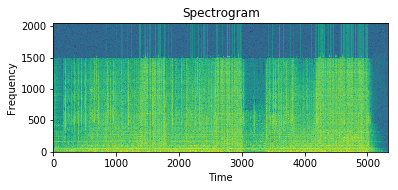

In [4]:
from matplotlib import mlab
from matplotlib import pyplot as plt

window_size = 2**12

window_overlap = int(window_size * 0.5)

dfreq = 44100

spectrogram = mlab.specgram(
                channel,
                NFFT=window_size,
                Fs=dfreq,
                window=mlab.window_hanning,
                noverlap=window_overlap)[0]

spectrogram = 10 * np.log10(spectrogram, out=np.zeros_like(spectrogram), where=(spectrogram != 0))

fig, axes = plt.subplots()
axes.imshow(spectrogram)
axes.set_xlabel('Time')
axes.set_ylabel('Frequency')
axes.set_title('Spectrogram')
plt.gca().invert_yaxis()
plt.show()

**Visualizing the tiny portion of audio signal**

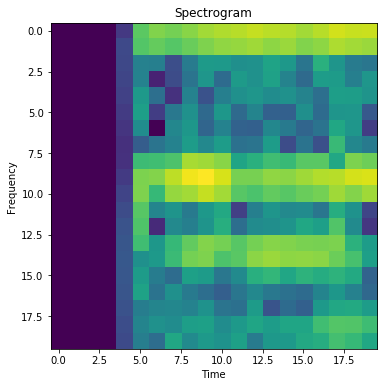

In [5]:

spectrogram_1 = spectrogram[0:20, 0:20]
fig, axes = plt.subplots(figsize=(6,6))
axes.imshow(spectrogram_1)
axes.set_xlabel('Time')
axes.set_ylabel('Frequency')
axes.set_title('Spectrogram')
plt.show()

**Understanding how to find peaks**

In [6]:
from scipy.ndimage.morphology import (generate_binary_structure,
                                      iterate_structure,
                                      binary_erosion,)

from scipy.ndimage.filters import maximum_filter

# generate_binary_structure

structure = generate_binary_structure(2, 2)
no_of_iteration = 2
neighborhood = iterate_structure(structure, no_of_iteration)
structure

C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [7]:
neighborhood

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

In [8]:
# iterate_structure

a_array = np.zeros([7,7])
a_array[0:2, 0:2] = 1
a_array[2:5, 3:6] = 1
a_array

array([[1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [9]:
neighborhood = iterate_structure(structure, 1) # for simplicity structure is repeated only once.
maximum_filter(a_array, footprint=neighborhood)

array([[1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [10]:
# binary_erosion

from scipy import ndimage
a = np.zeros((7,7), dtype=int)
a[1:6, 2:5] = 1
a[0:2, 0:2] = 1
print(a)
print('-----------------')
print(ndimage.binary_erosion(a, structure=neighborhood).astype(a.dtype))

[[1 1 0 0 0 0 0]
 [1 1 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 1 1 1 0 0]
 [0 0 0 0 0 0 0]]
-----------------
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


**Getting Peaks**

In [11]:
def get_peaks(specgram, no_of_iteration = 10, min_amplitude = 10):
    
    structure = generate_binary_structure(2, 2)
    neighborhood = iterate_structure(structure, no_of_iteration)

    local_max = maximum_filter(specgram, footprint=neighborhood) == specgram

    background = (specgram == 0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    # Applying XOR between matrices to get the boolean mask of specgram
    detected_peaks = local_max ^ eroded_background

    # just getting the peaks, their frequency and time
    peaks = specgram[detected_peaks].flatten()
    peak_freqs, peak_times = np.where(detected_peaks)

    # get indices for frequency and time
    peak_indices = np.where(peaks > min_amplitude)

    freqs = peak_freqs[peak_indices]
    times = peak_times[peak_indices]

    return list(zip(freqs, times))

**Visualizing Peaks**

Total number of peaks in this small portion: 26


C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


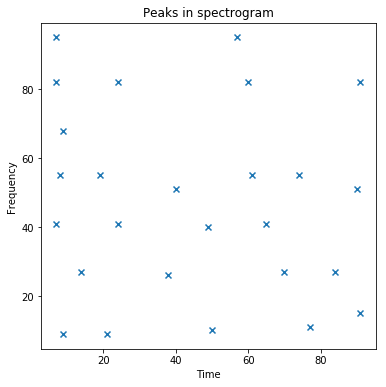

In [12]:
# Plotting small portion of spectrogram

spec_peaks = get_peaks(spectrogram[0:100, 0:100])
print('Total number of peaks in this small portion:', len(spec_peaks))
fig = plt.figure(figsize=(6, 6))
plot_peaks = np.array(spec_peaks)
plt.scatter(plot_peaks[:,1], plot_peaks[:,0], marker='x')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Peaks in spectrogram')
plt.show()

**Generating Hashes**

In [13]:
import pandas as pd
import hashlib
from operator import itemgetter

hash_func = lambda freq1, freq2, offset: hashlib.sha1(
    f"{str(freq1)}|{str(freq2)}|{str(offset)}".encode('utf-8')).hexdigest()[:25]

def get_hashes(peaks, peak_combination = 5):
    peaks.sort(key=itemgetter(1))

    freq_links = []
    for i in range(len(peaks)):
        for j in range(1, peak_combination):
            if (i + j) < len(peaks):

                freq1 = peaks[i][0]
                freq2 = peaks[i + j][0]
                t1 = peaks[i][1]
                t2 = peaks[i + j][1]
                t_delta = t2 - t1 
                freq_links.append((freq1, t1, freq2, t2, t_delta))

    freq_links = pd.DataFrame(freq_links, columns=['freq1', 'time1', 'freq2', 'time2', 'offset'])
    freq_links = freq_links[(freq_links.offset >= 0) & (freq_links.offset < 100)].reset_index(drop=True)
    freq_links['hash'] = freq_links.apply(lambda x: hash_func(x['freq1'], x['freq2'], x['offset']), axis=1)
    return freq_links

hash_df = get_hashes(spec_peaks)
print(hash_df.shape)
hash_df.head()

(94, 6)


,freq1,time1,freq2,time2,offset,hash
0,41,7,82,7,0,3d986a648edd4597ad32b3944
1,41,7,95,7,0,3a9945d16d7540a720be51db9
2,41,7,55,8,1,a0c042a6d163889cd53228003
3,41,7,9,9,2,df0f5cbcc8040e212accb687b
4,82,7,95,7,0,bfda7aa733b1668c1d785f8dd


**Visualizing combinatorial hashes**

[[40 49 10 50]
 [40 49 95 57]
 [40 49 82 60]
 [40 49 55 61]]


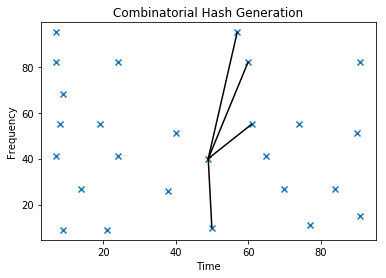

In [14]:
rand_n = hash_df.sample()
const_arr = hash_df[(hash_df['freq1'] == rand_n['freq1'].iloc[0]) & (hash_df['time1'] == rand_n['time1'].iloc[0])]
const_arr = const_arr.values[:, 0:4]
print(const_arr)


plt.scatter(plot_peaks[:,1], plot_peaks[:,0], marker='x')
for y1, x1, y2, x2 in const_arr:
    plt.plot([x1,x2],[y1,y2],'k-')

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Combinatorial Hash Generation')    
plt.show()

**Function for loading single audio file**

In [15]:
def load_file(file_name):
    audio_file = AudioSegment.from_file(file_name)

    audio_data = np.fromstring(audio_file.raw_data, np.int16)

    channels = []
    for chn in range(audio_file.channels):
        channels.append(audio_data[chn::audio_file.channels])
    return channels


**Function to find spectrogram for audio file**

In [16]:
def find_specgram(channel):
    window_size = 2**12
    window_overlap = int(window_size * 0.5)
    dfreq = 44100

    spectrogram = mlab.specgram(
                    channel,
                    NFFT=window_size,
                    Fs=dfreq,
                    window=mlab.window_hanning,
                    noverlap=window_overlap)[0]

    spectrogram = 10 * np.log10(spectrogram, out=np.zeros_like(spectrogram), where=(spectrogram != 0))
    return spectrogram

**Code snippet to load an audio file and get its hashes**

In [18]:
"""
file_name = './mp3/Something Just Like This-The Chainsmokers.mp3'
channels = load_file(file_name)

hash_df = pd.DataFrame(columns=['freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
for channel in channels:
    spectrogram = find_specgram(channel)
    peaks = get_peaks(spectrogram)
    hashes = get_hashes(peaks)
    hash_df = hash_df.append(hashes)

hash_df = hash_df.drop_duplicates(subset=['time1', 'hash'])
hash_df.reset_index(drop=True, inplace=True)
print(hash_df.shape)
hash_df.head()
"""

C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.
C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


(119449, 6)


,freq1,time1,freq2,time2,offset,hash
0,132,5,219,5,0,943c214210098351e5d3ad52c
1,132,5,307,5,0,82a38c058e3a13bc4f7156620
2,132,5,422,5,0,24af4beb7009e31173f976312
3,132,5,576,5,0,d1d4a7eeb0e9ec0785c6a5277
4,219,5,307,5,0,7d51389ef766735e1b5972253


**Function to load all the mp3 files in a directory and generate their hashes**

In [17]:
import os

def load_directory(path):
    
    hash_df = pd.DataFrame(columns=['song_id', 'song_name', 'freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
    song_id = 1
    
    for file_name in os.listdir(path):

        if file_name.endswith('.mp3'):
            song_name = file_name[:-4]
            print(f'Started reading file: {song_name} ...')
            channels = load_file(os.path.join('./mp3', file_name))

            for channel in channels:
                spectrogram = find_specgram(channel)
                peaks = get_peaks(spectrogram)
                hashes = get_hashes(peaks)
    
                hashes.loc[:, 'song_id'] = song_id
                hashes.loc[:, 'song_name'] = song_name
                hash_df = hash_df.append(hashes)
            print(f'Completed reading file: {song_name} ...\n')
            
            song_id += 1

    hash_df = hash_df.drop_duplicates(subset=['song_id', 'song_name', 'time1', 'hash'])
    hash_df.reset_index(drop=True, inplace=True)
    hash_df = hash_df[['song_id', 'song_name', 'freq1', 'time1', 'freq2', 'time2', 'offset', 'hash']]
    return hash_df

dir_path = './mp3/'
hash_df = load_directory(dir_path)
print(hash_df.shape)
hash_df.head()

Started reading file: Don't Let Me Down - The Chainsmokers ...


C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.
C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0
C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Completed reading file: Don't Let Me Down - The Chainsmokers ...

Started reading file: Hope - The Chainsmoker ...
Completed reading file: Hope - The Chainsmoker ...

Started reading file: Paris - The Chainsmokers ...
Completed reading file: Paris - The Chainsmokers ...

Started reading file: Something Just Like This-The Chainsmokers ...
Completed reading file: Something Just Like This-The Chainsmokers ...

(390040, 8)


,song_id,song_name,freq1,time1,freq2,time2,offset,hash
0,1,Don't Let Me Down - The Chainsmokers,444,4,597,4,0,4708f47e019ee9ed98d203567
1,1,Don't Let Me Down - The Chainsmokers,444,4,784,4,0,4491fd3009ef1192d725c8dcf
2,1,Don't Let Me Down - The Chainsmokers,444,4,891,4,0,e8c7945e86b1f59d5a206eed5
3,1,Don't Let Me Down - The Chainsmokers,444,4,38,5,1,ad2f8c2703391a14d7033512c
4,1,Don't Let Me Down - The Chainsmokers,597,4,784,4,0,1deff488a5ff3269f73ef7402


**Loading sample file for match**

In [18]:
# Input audio sample

sample_file_name = 'Hope - 1.mp3'
sample_file_path = os.path.join('./test/', sample_file_name)
song_name = sample_file_name[:-4]

sample_channels = load_file(sample_file_path)

sample_hash_df = pd.DataFrame(columns=['freq1', 'time1', 'freq2', 'time2', 'offset', 'hash'])
for channel in sample_channels:
    sample_specgram = find_specgram(channel)
    sample_peaks = get_peaks(sample_specgram)
    sample_hashes = get_hashes(sample_peaks)
    sample_hash_df = sample_hash_df.append(sample_hashes)

sample_hash_df = sample_hash_df.drop_duplicates(subset=['time1', 'hash'])
sample_hash_df.reset_index(drop=True, inplace=True)
print(sample_hash_df.shape)
sample_hash_df.head()

C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  after removing the cwd from sys.path.
C:\Users\ashwi\anaconda3\envs\audio\lib\site-packages\scipy\ndimage\morphology.py:114: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[slc] = structure != 0


(3868, 6)


,freq1,time1,freq2,time2,offset,hash
0,124,0,1035,0,0,de65b534f7b7b21719edb7618
1,124,0,797,1,1,6d3ef3c7da4de8ecad7cb1d0d
2,124,0,1113,1,1,8e97b64ba9add72ca9f533267
3,124,0,1065,2,2,6ed01024b9e9d67fb6a682072
4,1035,0,797,1,1,2bd434402a55202eafd8ee374


**Finding the match**

In [19]:
matches = []
for sid in hash_df.song_id.unique():
    temp_hash_df = hash_df[hash_df.song_id == sid]
    merge_df = temp_hash_df.merge(sample_hash_df, on='hash', suffixes=('_o', '_s'))
    merge_df['start_time_diff'] = merge_df.apply(lambda x: x['time1_o'] - x['time1_s'], axis=1)
    
    song_name = temp_hash_df.song_name.iloc[0]
    hashes_matched = temp_hash_df[temp_hash_df.hash.isin(sample_hash_df.hash.unique())].shape[0]
    try:
        match_time = merge_df['start_time_diff'].value_counts().index[0]
        matches_at_match_time = merge_df['start_time_diff'].value_counts().iloc[0]
    except KeyError:
        match_time = 'Error 404'
        matches_at_match_time = 'Error 404'
    
    matches.append((sid, song_name, hashes_matched, match_time, matches_at_match_time))

matches

[(1, "Don't Let Me Down - The Chainsmokers", 236, 2251, 5),
 (2, 'Hope - The Chainsmoker', 2066, 1334, 553),
 (3, 'Paris - The Chainsmokers', 430, 1535, 6),
 (4, 'Something Just Like This-The Chainsmokers', 434, 367, 4)]

**Sorting on the basis of number of matched fingerprints.**

In [22]:

best_match = sorted(matches, key=lambda x: x[2] if type(x[2]) == int else 0)[-1]

print('Best Match found in mp3 directory:')
print(f'Song id: {best_match[0]}')
print(f'Song name: "{best_match[1]}"')
print(f'Total fingerprint matches: {best_match[2]}')
print(f'Match time: {best_match[3]}')
print(f'Fingerprint matches at best match time: {best_match[4]}')

Best Match found in mp3 directory:
Song id: 2
Song name: "Hope - The Chainsmoker"
Total fingerprint matches: 2066
Match time: 1334
Fingerprint matches at best match time: 553


**Aligning Match**

In [23]:
temp_hash_df = hash_df[hash_df.song_id == 2]
merge_df = temp_hash_df.merge(sample_hash_df, on='hash', suffixes=('_o', '_s'))
merge_df['start_time_diff'] = merge_df.apply(lambda x: x['time1_o'] - x['time1_s'], axis=1)

match_time = merge_df['start_time_diff'].value_counts().index[0]
matches_at_match_time = merge_df['start_time_diff'].value_counts().iloc[0]

print(f'The sample audio matches with original song at time: {match_time}')
print(f'Total match with {match_time} offset is: {matches_at_match_time}')

The sample audio matches with original song at time: 1334
Total match with 1334 offset is: 553


**Visualizing the alignment**

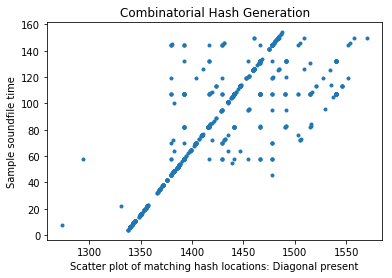

In [24]:
align_array = merge_df[(merge_df['start_time_diff'] >= (match_time -100)) & 
                       (merge_df['start_time_diff'] <= (match_time + 100) )][['time1_o', 'time1_s']].values

plt.scatter(align_array[:,0], align_array[:,1], marker='.')
plt.xlabel('Scatter plot of matching hash locations: Diagonal present')
plt.ylabel('Sample soundfile time')
plt.title('Combinatorial Hash Generation') 
plt.show()